In [1]:

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os , io
import shutil
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from keras.preprocessing import image
from keras import layers
from keras import models

In [3]:
# Set the path to the dataset directory
dataset_path = 'table_cells'

# Set the desired image size
image_size = (100,50)

# Initialize empty lists to store the images and their corresponding labels
images = []
labels = []

# Loop through each class folder
for class_folder in os.listdir(dataset_path):
    # Construct the full path to the class folder
    class_path = os.path.join(dataset_path, class_folder)
    
    # Check if the item is a directory (i.e., a class folder)
    if os.path.isdir(class_path):
        # Loop through each image file in the class folder
        for filename in os.listdir(class_path):
            # Construct the full path to the image file
            image_path = os.path.join(class_path, filename)
            
            # Load the image using cv2.imread()
            image1 = cv2.imread(image_path)
            
            # Resize the image to the desired size
            image2 = cv2.resize(image1, image_size)
            #image3 = np.reshape(image2, [-1,image_size])
            image3 = image2.astype('float32')
            image3 /= 255
            # Append the image and its corresponding label to the lists
            images.append(image3)
            label = keras.utils.to_categorical(class_folder, num_classes=31)
            #labels.append(numbers_to_strings(class_folder))
            labels.append(label)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Print the shapes of the arrays
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (13402, 50, 100, 3)
y shape: (13402, 31)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


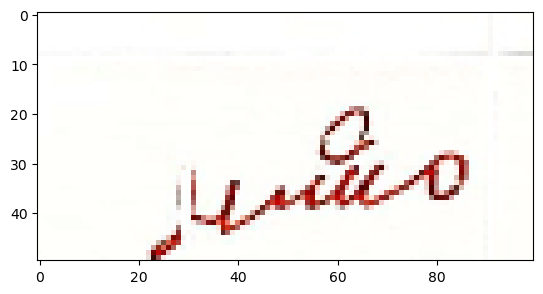

In [8]:
plt.imshow(images[955])
print(labels[955])

In [9]:
train_size=0.9
images, labels = np.array(images), np.array(labels)

# 1. Get the total size of the dataset
size = len(images)
# 2. Make an indices array and shuffle it, if required
indices = np.arange(size)
np.random.shuffle(indices)
# 3. Get the size of training samples
train_samples = int(size * train_size)
# 4. Split data into training and validation sets
x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

In [10]:
def encode_single_sample(img,label):
    
    img = tf.transpose(img, perm=[1, 0, 2])
    return img, label

In [11]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [12]:
a, b = next(iter(train_dataset))
print(a.shape)
print(b.shape)

(32, 100, 50, 3)
(32, 31)


In [13]:
from tensorflow.keras.layers import LSTM, TimeDistributed,Bidirectional
from tensorflow.keras import models, layers

model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 50, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

# Calculate the new shape after the convolutional and pooling layers
new_shape = (4, 1, 128)

model_2.add(layers.Reshape(new_shape))

# Add the first RNN layer
model_2.add(TimeDistributed(LSTM(64, return_sequences=True)))

# Add the second RNN layer
model_2.add(TimeDistributed(LSTM(64)))

model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(31, activation='softmax'))

model_2.summary()
model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 9, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 4, 128)       

In [14]:
epochs = 50
early_stopping_patience = 5
reduce_lr_patience=5

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=reduce_lr_patience)

# Train the model
history = model_2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/50


377/377 [==============================] - 40s 77ms/step - loss: 2.6053 - acc: 0.2288 - val_loss: 1.9472 - val_acc: 0.3848 - lr: 0.0010
Epoch 2/50
377/377 [==============================] - 31s 81ms/step - loss: 1.6915 - acc: 0.4819 - val_loss: 1.4461 - val_acc: 0.5638 - lr: 0.0010
Epoch 3/50
377/377 [==============================] - 31s 83ms/step - loss: 1.2944 - acc: 0.6170 - val_loss: 1.0964 - val_acc: 0.6793 - lr: 0.0010
Epoch 4/50
377/377 [==============================] - 33s 87ms/step - loss: 1.0103 - acc: 0.7072 - val_loss: 0.9169 - val_acc: 0.7450 - lr: 0.0010
Epoch 5/50
377/377 [==============================] - 33s 88ms/step - loss: 0.8086 - acc: 0.7662 - val_loss: 0.7298 - val_acc: 0.7987 - lr: 0.0010
Epoch 6/50
377/377 [==============================] - 33s 88ms/step - loss: 0.6603 - acc: 0.8104 - val_loss: 0.6212 - val_acc: 0.8307 - lr: 0.0010
Epoch 7/50
377/377 [==============================] - 35s 92ms/step - loss: 0.5533 - acc: 0.8432 - val_loss: 0.6027 

In [15]:
model_2.evaluate(validation_dataset)

42/42 [==============================] - 1s 27ms/step - loss: 0.8263 - acc: 0.8896


[0.8263319134712219, 0.8896346092224121]

Text(0, 0.5, 'Accuracy [%]')

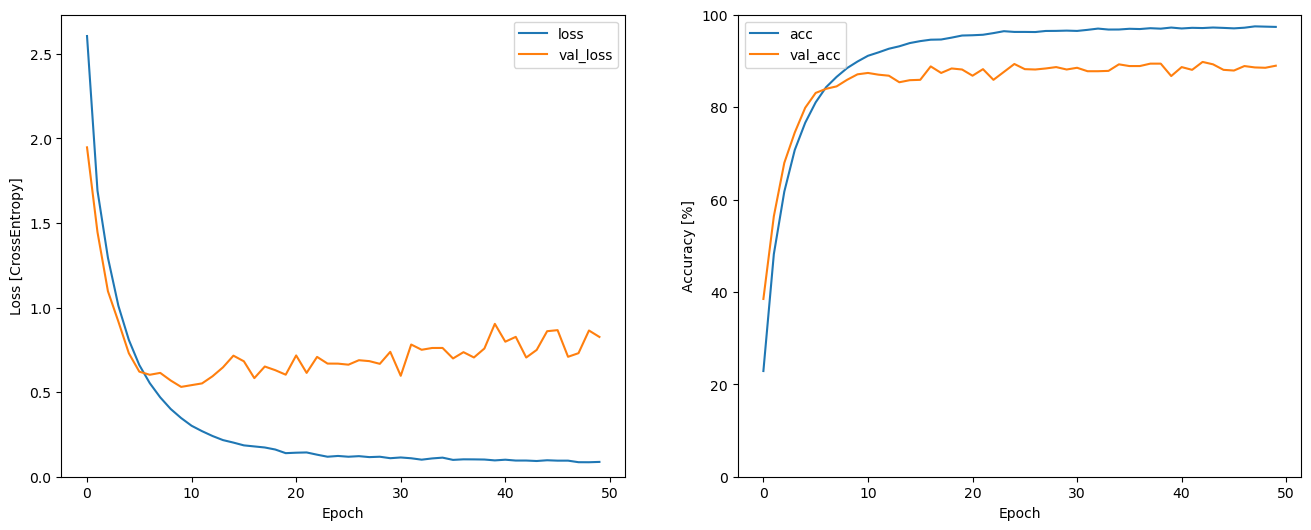

In [16]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['acc']), 100*np.array(metrics['val_acc']))
plt.legend(['acc', 'val_acc'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [19]:
import numpy as np

# Load the image you want to predict
#image_path = 'table_cells/table_cells_class02/26/rwaw6wDrQi.jpg'
image_path = 'c2.jpg'
image = cv2.imread(image_path)

# Preprocess the image to match the model's input size
image = cv2.resize(image, image_size)
image = image.astype('float32')
image /= 255
image = tf.transpose(image, perm=[1, 0, 2])
# Expand the dimensions to match the model's input shape
image = np.expand_dims(image, axis=0)

# Use the model to predict the class probabilities
predictions = model_2.predict(image)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]

# Print the predicted class label
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 27ms/step
Predicted class: 10


In [20]:

# Save the model
model_2.save('my_model_project.h5')
print("Model saved to 'my_model_project.h5'")

C:\Users\farassoo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to 'my_model_project.h5'


In [21]:
loaded_model = tf.keras.models.load_model('my_model_project.h5')


In [22]:
loaded_model = tf.keras.models.load_model('my_model_project.h5')
import numpy as np
import cv2
# Load the image you want to predict
image_path = 'C:/Users/farassoo/c2.jpg'
image_size = (100,50)
image = cv2.imread(image_path)

# Preprocess the image to match the model's input size
image = cv2.resize(image, image_size)
image = image.astype('float32')
image /= 255
image = tf.transpose(image, perm=[1, 0, 2])
# Expand the dimensions to match the model's input shape
image = np.expand_dims(image, axis=0)

# Use the model to predict the class probabilities
predictions =loaded_model.predict(image)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]

# Define a mapping between class labels and their names
class_names = ['rasht', 'shiraz', 'shahrkord', 'tabriz', 'khoram-abad', 'qazvin', 'birjand',
              'orumie', 'sari', 'qom', 'mashhad', 'ardebil', 'arak', 'sanandaj',
              'bojnoord', 'esfahan', 'bandar-abbas', 'kerman', 'ahvaz', 'karaj',
              'hamedan', 'kermanshah ', 'zanjan', 'ilam', 'yazd', 'yasooj',
              'semnan', 'booshehr', 'gorgan', 'zahedan', 'tehran']

# Print the predicted class name
print("Predicted class:", class_names[predicted_class])


1/1 [==============================] - 1s 819ms/step
Predicted class: mashhad
